Here we'll look at what happens if we take our image data as a probability of a 1 and see how we can reconstruct an original frame of data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

In [261]:
# Code to quickly get a frame of video
from src.sources.capture import VideoSource


video = VideoSource()
video.start()

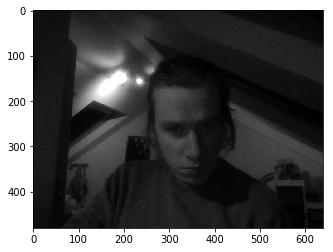

In [262]:
frame = video.read()[1][:, :, 1]

plt.imshow(frame, cmap="gray")

In [263]:
from src.var_processor.pb_threshold import pb_threshold

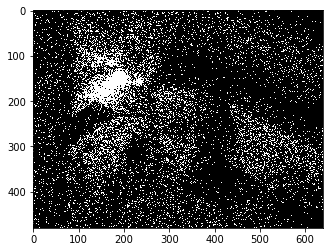

In [264]:
plt.imshow(pb_threshold(frame), cmap="gray")

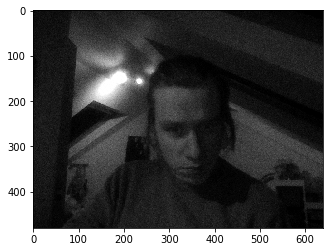

In [265]:
frame_sum = pb_threshold(frame)
for i in range(0, 255):
    frame_sum += pb_threshold(frame)
plt.imshow(frame_sum, cmap="gray")

We treat each pixel as a separate sensor stream. (We can later look at using matrices to perform for all pixels in parallel).

How do we generate a processing pipeline?

We just have an iterate method that takes in new data? We then have methods to output the average value and to receive the average value from the next unit. It's similar to the PE units we originally designed.

Our buffers just receive binary signals. So our iterate can receive a signal as an input.

In [21]:
video.stop()

## Buffer Development

We can tweak our existing time buffer.

We need to watch overflow if we are performing subtraction. If we imagine our values are probabilities, we want to maintain within the range of 0 to 1 (or 0 to 255 / 255). See https://stackoverflow.com/questions/25493500/numpy-subtract-but-only-until-difference-reaches-threshold-replace-numbers-sma

In [53]:
a = np.arange(0, 10, 1).astype(np.uint8); print(a)
b = np.flip(a); print(b)
c = a - b
print(c, c.dtype)
d = c.astype(np.int8); print(d)
clipped = np.clip(c, 0, 255).astype(np.uint8); print(clipped)
clipped2 = np.clip(d, 0, 255).astype(np.uint8); print(clipped2)
clipped3 = np.clip(d, 0, np.max(d)).astype(np.uint8); print(clipped3)

[0 1 2 3 4 5 6 7 8 9]
[9 8 7 6 5 4 3 2 1 0]
[247 249 251 253 255   1   3   5   7   9] uint8
[-9 -7 -5 -3 -1  1  3  5  7  9]
[247 249 251 253 255   1   3   5   7   9]
[  0   0   0   0   0 255 255 255 255 255]
[0 0 0 0 0 1 3 5 7 9]


In [75]:

class Buffer:
    """Object for a time buffer."""

    def __init__(self, rows, cols, length):
        """Initialise object.

        Assumes 8-bit values (for now).
        """
        # Set up an array to store a rolling window of inputs
        self.array = np.zeros(shape=(rows, cols, length), dtype=np.uint8)
        # Initialise feedback mean
        self.feedback_theta = np.zeros(shape=(rows, cols), dtype=np.uint8)
        # Initialise variable that provides a rolling count
        self.rolling_count = 0
        # Initialise flag to indicate when a full buffer cycle is reached
        self.flag = False
        self.length = length

    def add(self, frame):
        """Add a frame to the buffer."""
        # Roll array
        self.array = np.roll(self.array, -1, axis=2)
        # Add frame to end of buffer
        self.array[..., -1] = frame
        self.rolling_count += 1
        if self.rolling_count == self.length:
            # Toggle flag & reset count
            self.flag = True
            self.rolling_count = 0
        else:
            self.flag = False
        return None

    @property
    def average(self):
        """Average frames in the buffer."""
        return np.mean(self.array, axis=2)

    @property
    def latest(self):
        """Return latest entry in buffer."""
        return self.array[..., -1]

    def feedback(self, fb_theta):
        """Update the feedback theta or mean."""
        # Check shape
        if fb_theta.shape == self.feedback_theta.shape:
            self.feedback_theta = fb_theta
        return None

    @property
    def output(self):
        """Output the adjusted theta."""
        # Calculate difference
        adjusted = (self.average - self.feedback_theta).astype(np.int8)
        # Limit to positive values in fixed range
        clipped = np.clip(adjusted, 0, np.max(adjusted)).astype(np.uint8)
        return clipped

In [76]:
a = np.arange(0,4).reshape(2,2); print(a)

[[0 1]
 [2 3]]


In [77]:
(a+a)/2

array([[0., 1.],
       [2., 3.]])

In [78]:
np.clip(a - (a*2 - 1), 0, 1)

array([[1, 0],
       [0, 0]])

In [79]:
# Tests

def test_buffer():
    """Test the buffer object and methods."""
    b = Buffer(2,2,2)
    a = np.arange(0,4).reshape(2,2)
    b.add(a)
    assert np.array_equal(b.latest, a)
    b.add(a)
    assert np.array_equal(b.latest, a)
    b.add(a)
    assert np.array_equal(b.latest, a)
    average = b.average
    # Average will equal a
    assert np.array_equal(average, a)
    fb_theta = (a*2 - 1)
    b.feedback(fb_theta)
    assert np.array_equal(b.feedback_theta, fb_theta)
    output = b.output
    assert np.array_equal(output, np.clip(a - (a*2 - 1), 0, 1))

In [80]:
test_buffer()

In [81]:
b = Buffer(2,2,2)
a = np.arange(0,4).reshape(2,2)
b.add(a)
assert np.array_equal(b.latest, a)
b.add(a)
assert np.array_equal(b.latest, a)
b.add(a)
assert np.array_equal(b.latest, a)
average = b.average
# Average will equal a
assert np.array_equal(average, a)
fb_theta = (a*2 - 1)
b.feedback(fb_theta)
assert np.array_equal(b.feedback_theta, fb_theta)
output = b.output
assert np.array_equal(output, np.clip(a - (a*2 - 1), 0, 1))

## Two Buffers in Series

We can base things on this: https://github.com/benhoyle/predictive_coding/blob/master/2019-10-28%20SpaceTime%20Grid%20object%20development.ipynb.

The idea of a flag to indicate in a loop when things should happen is good. This can be controlled by the buffer itself so we can do things statelessly.

In [82]:
shape = (1, 2, 3)
print(*shape, shape)

1 2 3 (1, 2, 3)


In [98]:
ran = range(0,2)
for i, r in enumerate(ran):
    print(i, r, i<len(ran)-1)

0 0 True
1 1 False


In [106]:
class TimeSeries:
    """Generate a cascade of time buffers."""

    def __init__(self, rows, cols, length):
        """Initialise list for buffer series.
        
        Args:
            rows - integer indicating input array (frame) height in rows.
            cols - integer indicating input array (frame) width in cols.
            length - integer indicating number of time steps to buffer.
        """
        self.time_series = list()
        self.shape = (rows, cols, length)
        self.time_series.append(Buffer(*self.shape))
        # Initialise input iteration count
        self.count = 0
        return None

    def add(self, frame):
        """Add frame for processing.
        
        This runs for each time iteration. Individual buffers are updated
        at a lower clock rate due to the flags.
        """
        flag = True
        # Iterate through buffers in series
        for i, buffer in enumerate(self.time_series):
            # If flag of previous buffer indicates data add to current buffer
            if flag:
                buffer.add(frame)
            flag = buffer.flag
            if flag:
                # Get feedback from next buffer if not last buffer
                if i < (len(self.time_series)-1):
                    feedback_in = self.time_series[i+1].output
                    buffer.feedback(feedback_in)
                # Set frame as buffer output
                frame = buffer.output

        # If last time scale is full then add new buffer
        if flag == 1:
            new_buffer = Buffer(*self.shape)
            new_buffer.add(frame)
            self.time_series.append(
                new_buffer
            )
        return None

    def output(self):
        """Get data as numpy array."""
        return np.asarray([buffer.output for buffer in self.time_series]) 

In [178]:
5 % 2

1

In [193]:
class TimeSeries:
    """Generate a cascade of time buffers."""

    def __init__(self, rows, cols, length):
        """Initialise list for buffer series.
        
        Args:
            rows - integer indicating input array (frame) height in rows.
            cols - integer indicating input array (frame) width in cols.
            length - integer indicating number of time steps to buffer.
        """
        self.time_series = list()
        self.shape = (rows, cols, length)
        self.time_series.append(Buffer(*self.shape))
        # Initialise input iteration count
        self.count = 0
        return None

    def add(self, frame):
        """Add frame for processing.
        
        This runs for each time iteration. Individual buffers are updated
        at a lower clock rate due to the flags.
        """
        length = self.shape[2]
        # Iterate through buffers in series
        for i, buffer in enumerate(self.time_series):
            if (self.count % length**i) == 0:
                buffer.add(frame)
                # Get feedback from next buffer if not last buffer
                if i < (len(self.time_series)-1):  # Add here that self.count % length**(i+1)
                    feedback_in = self.time_series[i+1].output
                    buffer.feedback(feedback_in)
                frame = buffer.output
        # Increment count
        self.count += 1
        # If we need to add a new buffer
        if self.count == length**len(self.time_series): 
            self.time_series.append(
                Buffer(*self.shape)
            )
            # Reset count
            self.count = 0
        return None

    def output(self):
        """Get data as numpy array."""
        return np.asarray([buffer.output for buffer in self.time_series]) 

In [194]:
4 % 4**1

0

We could also internalise the flag behaviour so that we just did an "add" to each buffer in the list on each low-level iteration and then the "add" worked out whether an internal update is to be performed.

How do we apply the feedback?

The feedback is needed when we obtain the output. So we can fetch this before getting the output. Although it won't really be ready until a number of iterations in the future..

I don't think the logic above is right...

In [195]:
np.ones(shape=(2, 2))

array([[1., 1.],
       [1., 1.]])

In [196]:
a = np.random.randint(255, size=(2,2)); print(a)

[[ 35 175]
 [ 60  98]]


In [197]:
ts = TimeSeries(2, 1, 4)
a = np.ones(shape=(2, 1))
assert len(ts.time_series) == 1
for i in range(0, 5):
    ts.add(a)
    print(ts.time_series[0].array)
assert len(ts.time_series) == 2
out = ts.output()
assert out.shape[0] == 2

[[[0 0 0 1]]

 [[0 0 0 1]]]
[[[0 0 1 1]]

 [[0 0 1 1]]]
[[[0 1 1 1]]

 [[0 1 1 1]]]
[[[1 1 1 1]]

 [[1 1 1 1]]]
[[[1 1 1 1]]

 [[1 1 1 1]]]


In [198]:
out

array([[[1],
        [1]],

       [[0],
        [0]]], dtype=uint8)

In [146]:
out.shape

(2, 2, 2)

In [225]:
for i in range(0, 17):
    ts.add(a)

In [226]:
ts.output()

array([[[1],
        [1]],

       [[0],
        [0]],

       [[0],
        [0]],

       [[0],
        [0]]], dtype=uint8)

Ah - we need to apply the feedback as well.

In [ ]:
def test_time_series():
    """Test time series object."""
    ts = TimeSeries(2, 2, 2)
    a = np.ones(shape=(2, 2))
    assert len(ts.time_series) == 1
    ts.add(a)
    ts.add(a)
    ts.add(a)
    assert len(ts.time_series) == 2
    out = ts.output()
    assert out.shape[2] == 2
    

In [ ]:
for i in range(0, 1000):
    a = np.random.randint(255, size=(2,1))
    ts.add(a)

In [256]:
ts.output()

array([[[88],
        [73]],

       [[51],
        [63]],

       [[11],
        [14]],

       [[10],
        [16]],

       [[ 9],
        [ 9]],

       [[ 5],
        [ 6]],

       [[ 4],
        [ 5]]], dtype=uint8)

In [260]:
ts.output().sum(axis=0)

array([[178],
       [186]], dtype=uint64)

## Video Testing

Testing on video data.

In [282]:
frame = video.read()[1][:, :, 1]
video_ts = TimeSeries(*frame.shape, 16)
print(video_ts.shape)

(480, 640, 16)


<IPython.core.display.Javascript object>


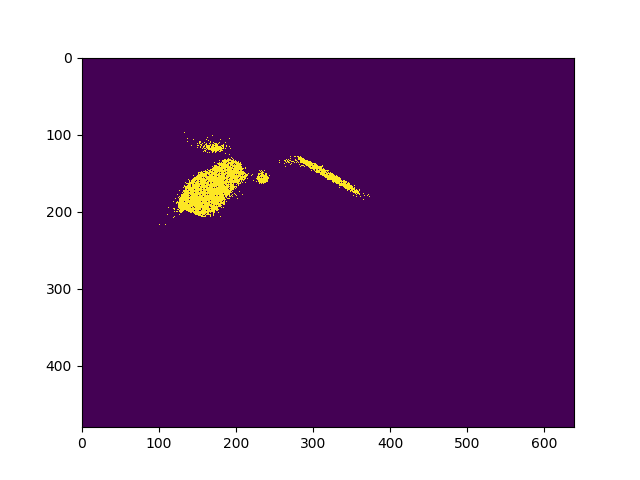

In [283]:
for i in range(0, 100):
    frame = video.read()[1][:, :, 1]
    thresholded = pb_threshold(frame)
    video_ts.add(thresholded)
plt.imshow(video_ts.output().sum(axis=0))

In [284]:
len(video_ts.time_series)

2

<IPython.core.display.Javascript object>


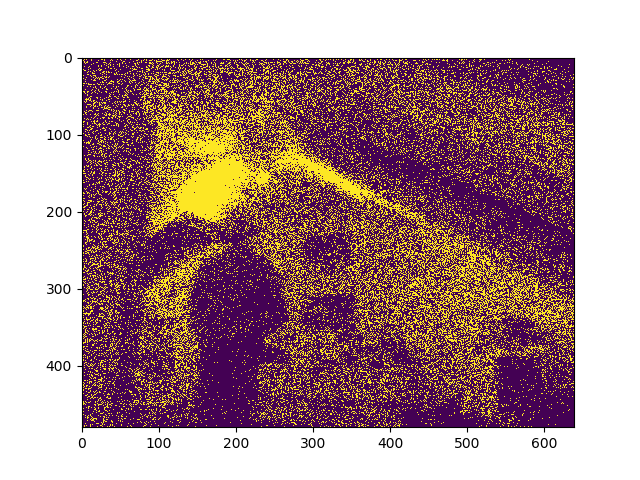

In [285]:
plt.imshow(video_ts.time_series[0].latest)

<IPython.core.display.Javascript object>


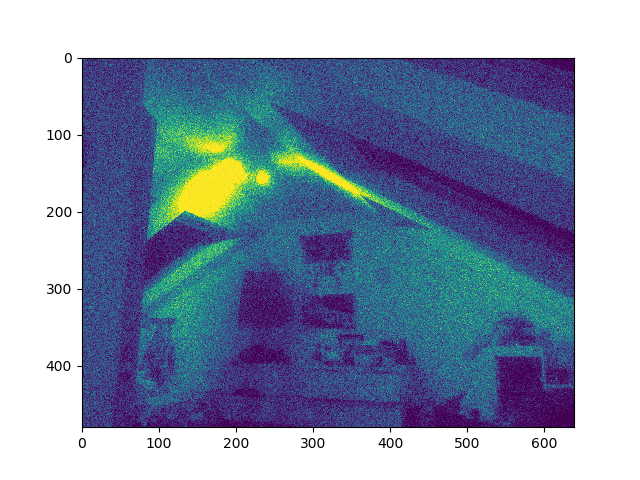

In [288]:
plt.imshow(video_ts.time_series[0].average)

<IPython.core.display.Javascript object>


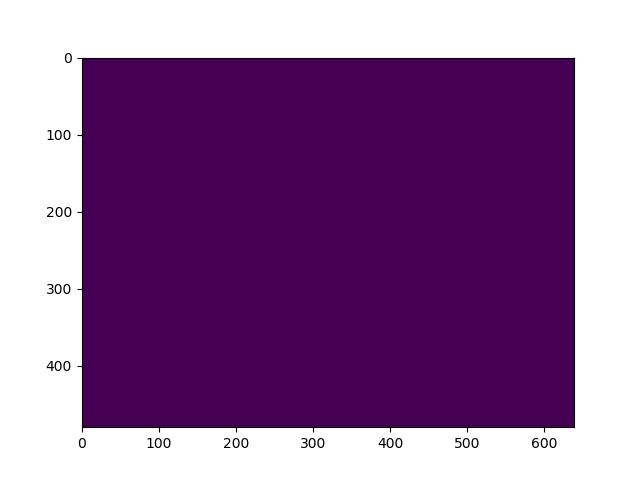

In [290]:
plt.imshow(video_ts.time_series[0].feedback_theta)

In [292]:
adj = video_ts.time_series[0].average - video_ts.time_series[0].feedback_theta; print(adj)

[[0.0625 0.125  0.125  ... 0.0625 0.     0.    ]
 [0.     0.125  0.1875 ... 0.     0.     0.    ]
 [0.125  0.0625 0.1875 ... 0.0625 0.     0.    ]
 ...
 [0.125  0.375  0.1875 ... 0.     0.     0.    ]
 [0.1875 0.125  0.375  ... 0.     0.     0.    ]
 [0.125  0.125  0.     ... 0.     0.     0.    ]]


In [293]:
print(adj.astype(np.int8))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Aha - there you go - we have fractions and we casting to ints!

<IPython.core.display.Javascript object>


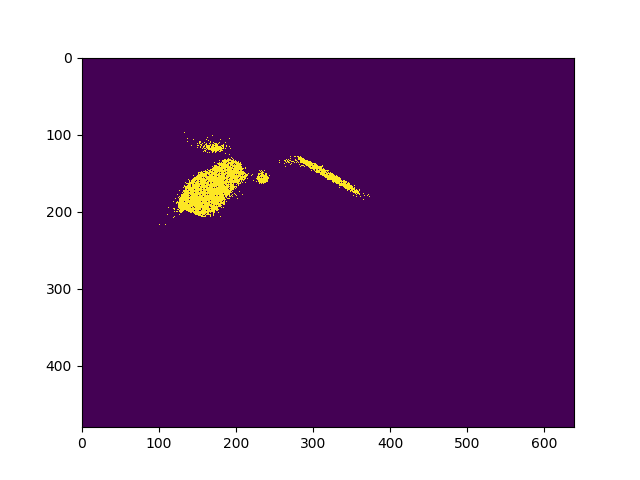

In [289]:
plt.imshow(video_ts.time_series[0].output)

Something is going wrong with our output.

<IPython.core.display.Javascript object>


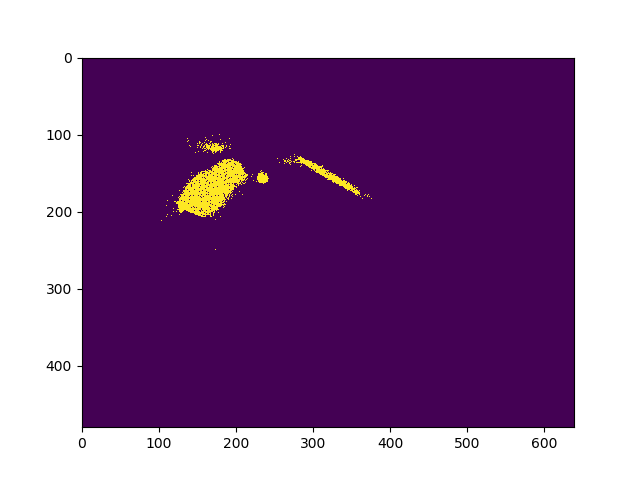

In [286]:
plt.imshow(video_ts.time_series[1].latest)

<IPython.core.display.Javascript object>


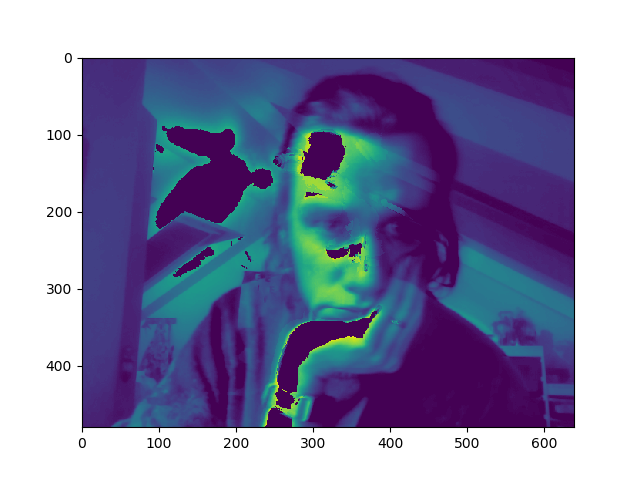

In [279]:
plt.imshow(video_ts.time_series[2].latest)

<IPython.core.display.Javascript object>


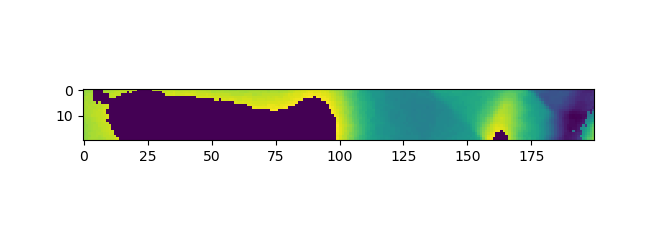

In [276]:
%matplotlib notebook
plt.imshow(video_ts.time_series[1].latest[90:110, 100:300])

The areas are sections of 0. They also relate to high intensity regions in the earlier images (e.g. 255+).

<IPython.core.display.Javascript object>


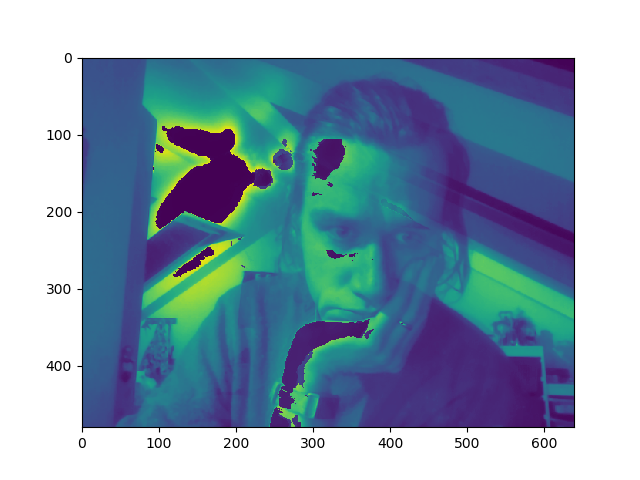

In [280]:
plt.imshow(video_ts.output().sum(axis=0))